# Lab 05: MobileNet
Reference:
- MobileNet V1: MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications, https://arxiv.org/abs/1704.04861

## 1. Xây dựng MobileNet bằng tf.keras.layers

Trong phần này chúng ta sẽ xây dựng và huấn luyện model ResNet-34 trên dataset MNIST (ảnh được resize)

In [0]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt


In [0]:
from tensorflow.keras.layers import Input, Dense, DepthwiseConv2D, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2


class BottleneckDepthSeparableConvolutionWithResiduals(keras.layers.Layer):

  def __init__(self, n_filters=64, expansion_factor=6, l2_regularizer=0.0, down_sampling=False):
      ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
      super(BottleneckDepthSeparableConvolutionWithResiduals, self).__init__()
      self.n_filters = n_filters
      self.down_sampling = down_sampling
      self.l2_regularizer = l2_regularizer
      self.expansion_factor = expansion_factor
  
  def get_config(self):
      config = super(BottleneckDepthSeparableConvolutionWithResiduals, self).get_config()
      config.update({
          "n_filters": self.n_filters,
          "down_sampling": self.down_sampling})
      return config

  def build(self, input_shape):

      ## Nếu cần down sampling thì convolutional layer dùng strides=[2,2]
      strides = [1,1]
      if self.down_sampling:
        strides = [2,2]

      # Block 1
      self.expand_conv = Convolution2D(filters = 6*input_shape[-1],
                                       kernel_size=[1,1],
                                       strides=[1,1],
                                       padding='same',
                                       use_bias=False,
                                       kernel_regularizer=l2(l2_regularizer_rate),
                                       activation=None)
      self.expand_batch = BatchNormalization()
      self.expand_relu = ReLU()

      # Block 2
      self.depthwise_conv = DepthwiseConv2D(kernel_size=[3,3],
                                            strides=strides,
                                            padding='same',
                                            use_bias=False,
                                            activation=None)
      self.depthwise_batch = BatchNormalization()
      self.depthwise_relu = ReLU()

      # Block 3
      self.pointwise_conv = Convolution2D(filters=self.n_filters,
                                            kernel_size=[1,1],
                                            strides=[1,1],
                                            padding='same',
                                            use_bias=False,
                                            kernel_regularizer=l2(self.l2_regularizer),
                                            activation=None)
      self.pointwise_batch = BatchNormalization()
      

  def call(self, inputs):
      # 1
      expand_conv = self.expand_conv(inputs)
      expand_batch = self.expand_batch(expand_conv)
      expand_relu = self.expand_relu(expand_batch)
      
      # 2
      depthwise_conv = self.depthwise_conv(expand_relu)
      depthwise_batch = self.depthwise_batch(depthwise_conv)
      depthwise_relu = self.depthwise_relu(depthwise_batch)
      
      #3
      pointwise_conv = self.pointwise_conv(depthwise_relu)
      pointwise_batch = self.pointwise_batch(pointwise_conv)

      if self.down_sampling or (inputs.shape[-1] != pointwise_batch.shape[-1]):
        return pointwise_batch
      else: 
        return pointwise_batch + inputs

In [0]:
mobilenetv2 = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32,32,1), 
                                                   alpha=1.0,  
                                                   include_top=True, 
                                                   weights=None, 
                                                   input_tensor=None, 
                                                   pooling=None, 
                                                   classes=10)
mobilenetv2.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      

In [0]:
l2_regularizer_rate = 0.0

inputs = keras.layers.Input(shape=(32,32,1))
conv1 = Convolution2D(filters=32,
                      kernel_size=[3,3],
                      strides=[2,2],
                      padding='same',
                      use_bias=False,
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)
bn_conv1 = BatchNormalization()(conv1)        
conv1_relu = ReLU()(bn_conv1)

expanded_conv_depthwise = DepthwiseConv2D(kernel_size=[3,3],
                                          strides = [1,1],
                                          padding='same',
                                          use_bias=False,
                                          activation=None)(conv1_relu)
expanded_conv_depthwise_BN = BatchNormalization()(expanded_conv_depthwise)
expanded_conv_depthwise_relu = ReLU()(expanded_conv_depthwise_BN)

expanded_conv_project = Convolution2D(filters=16,
                                      kernel_size=[1,1],
                                      strides=[1,1],
                                      padding='same',
                                      use_bias=False,
                                      kernel_regularizer=l2(l2_regularizer_rate),
                                      activation=None)(expanded_conv_depthwise_relu)
expanded_conv_project_BN = BatchNormalization()(expanded_conv_project)
print(expanded_conv_project_BN.shape)

# Block 1
bottleneck1_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=24, expansion_factor = 6, l2_regularizer=0.0, down_sampling = True)(expanded_conv_project_BN)
bottleneck1_2 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=24, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck1_1)
# print(bottleneck1_2.shape)  

# Block 2
bottleneck2_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=32, expansion_factor = 6, l2_regularizer=0.0, down_sampling = True)(bottleneck1_2)
bottleneck2_2 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=32, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck2_1)
bottleneck2_3 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=32, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck2_2)
# print(bottleneck2_3.shape)

# Block 3
bottleneck3_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=64, expansion_factor = 6, l2_regularizer=0.0, down_sampling = True)(bottleneck2_3)
bottleneck3_2 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=64, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck3_1)
bottleneck3_3 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=64, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck3_2)
bottleneck3_4 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=64, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck3_3)
# print(bottleneck3_4.shape)

# Block 4
bottleneck4_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=96, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck3_4)
bottleneck4_2 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=96, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck4_1)
bottleneck4_3 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=96, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck4_2)
# print(bottleneck4_3.shape)

# Block 5
bottleneck5_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=160, expansion_factor = 6, l2_regularizer=0.0, down_sampling = True)(bottleneck4_3)
bottleneck5_2 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=160, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck5_1)
bottleneck5_3 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=160, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck5_2)
# print(bottleneck5_3.shape)

# Block 6
bottleneck6_1 = BottleneckDepthSeparableConvolutionWithResiduals(n_filters=320, expansion_factor = 6, l2_regularizer=0.0, down_sampling = False)(bottleneck5_3)
# print(bottleneck6_1.shape)

conv_1 = Convolution2D(filters=1280,
                      kernel_size=[1,1],
                      strides=[1,1],
                      padding='same',
                      use_bias=False,
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(bottleneck6_1)
conv_1_bn = BatchNormalization()(conv_1)        
out_relu = ReLU()(conv_1_bn)

avage_pool = GlobalAveragePooling2D()(out_relu)
softmax = Dense(units=10, activation='softmax')(avage_pool)

## Compile model
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(), 
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

(?, 16, 16, 16)
Cấu trúc của model: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)          

### 1.3 Resize MNIST

In [0]:

# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
## import thư viện OpenCV trên python
#!pip3 install opencv-python

### Thử resize một ảnh
import cv2
resized_img = cv2.resize(X_train[0], dsize=(32,32))
print("Kích thước ảnh sau resize: ", resized_img.shape)

Kích thước ảnh sau resize:  (32, 32)


Kích thước tập sau khi resize:  (60000, 32, 32) (10000, 32, 32)


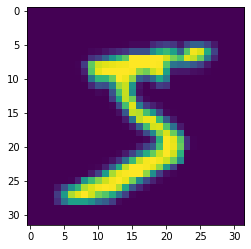

Kích thước tập sau khi reshape:  (60000, 32, 32, 1) (10000, 32, 32, 1)


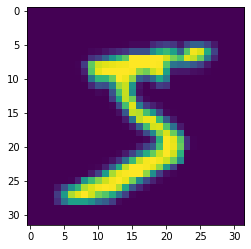

In [0]:
## Resize toàn bộ ảnh train tập train và test
X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(32,32)) for img in X_test])
print("Kích thước tập sau khi resize: ", X_train.shape, X_test.shape)

## In xem ảnh còn ổn không sau khi resize
plt.imshow(X_train[0])
plt.show()

## Reshape ảnh để phù hợp với input của model (thêm một trục)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Kích thước tập sau khi reshape: ", X_train.shape, X_test.shape)

plt.imshow(X_train[0,:,:,0])
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

## Reshape ảnh để phù hợp với input của model (thêm một trục)

### 1.4 Train

In [0]:
# Checkpoint Callback
mc = keras.callbacks.ModelCheckpoint(filepath="mobilenet_mnist.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)

## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])                    

## Load lại model tốt nhất đã lưu
print("best model: ")
model.load_weights("mobilenet_mnist.h5")
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 45s 837us/sample - loss: 0.4758 - acc: 0.8470 - val_loss: 2.3757 - val_acc: 0.1728
Epoch 2/10
54000/54000 [==============================] - 31s 566us/sample - loss: 0.1195 - acc: 0.9650 - val_loss: 0.1007 - val_acc: 0.9723
Epoch 3/10
54000/54000 [==============================] - 31s 569us/sample - loss: 0.0827 - acc: 0.9764 - val_loss: 0.0757 - val_acc: 0.9790
Epoch 4/10
54000/54000 [==============================] - 30s 556us/sample - loss: 0.0661 - acc: 0.9818 - val_loss: 0.1083 - val_acc: 0.9753
Epoch 5/10
54000/54000 [==============================] - 30s 555us/sample - loss: 0.0591 - acc: 0.9836 - val_loss: 0.0894 - val_acc: 0.9798
Epoch 6/10
54000/54000 [==============================] - 31s 569us/sample - loss: 0.0558 - acc: 0.9846 - val_loss: 0.0751 - val_acc: 0.9820
Epoch 7/10
54000/54000 [==============================] - 30s 559us/sample - loss: 0.0571 - acc: 0.9847 -